In [1]:
import matplotlib.pyplot as plt

import torch
from torch import nn
print(torch.__version__)

2.1.0


In [2]:
# setup device agnostic code
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# PyTorch Workflow

Machine learning is a game of two parts:

1. get data into a numerical representation
2. build a model to learn patterns in that numerical representation

## Data preparing and loading

In [3]:
def dataviz(*args, optional_label=None):
  """
    Generate a data visualization to compare training and test data along with predictions.

    Args:
      *data (tuple): A tuple containing the following elements in order:
        data[0] (array-like): X_train data for training.
        data[1] (array-like): y_train data for training.
        data[2] (array-like or none): X_test data for testing, or None if no test data is available.
        data[3] (array-like or none): y_test data for testing, or None if no test data is available.
        data[4] (array-like or None): y_pred data for predictions, or None if no predictions are available.

      optional_label (str, optional): A custom label for the test data in the plot. If not provided,
        it defaults to 'Test data'.

    This function generates a data visualization plot that allows for the visual comparison of
    training data (in blue), test data (in green), and predictions (in red) if available. You can
    specify a custom label for the test data in the plot using the optional_label parameter.

    Returns:
        None
  """
  plt.figure(figsize=(10, 7))

  # plot training data in blue
  plt.scatter(args[0], args[1], c="blue", s=4, label='Training data')

  # plot test data in green
  if len(args) > 2 and args[2] is not None and args[3] is not None:
    plt.scatter(args[2], args[3], c="green", s=4, label=optional_label or 'Test data')

  # plot predictions in red
  if len(args) > 4 and args[4] is not None:
    plt.scatter(args[2], args[4], c="red", s=4, label='Predictions')

  plt.legend(prop={'size': 14})

In [5]:
X = torch.arange(start=0, end=1, step=0.02).to(device)
X, X.device

(tensor([0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.1000, 0.1200, 0.1400, 0.1600,
         0.1800, 0.2000, 0.2200, 0.2400, 0.2600, 0.2800, 0.3000, 0.3200, 0.3400,
         0.3600, 0.3800, 0.4000, 0.4200, 0.4400, 0.4600, 0.4800, 0.5000, 0.5200,
         0.5400, 0.5600, 0.5800, 0.6000, 0.6200, 0.6400, 0.6600, 0.6800, 0.7000,
         0.7200, 0.7400, 0.7600, 0.7800, 0.8000, 0.8200, 0.8400, 0.8600, 0.8800,
         0.9000, 0.9200, 0.9400, 0.9600, 0.9800]),
 device(type='cpu'))

In [6]:
weight = 0.7
bias = 0.3

y = (bias + weight * X).to(device)
y, y.device

(tensor([0.3000, 0.3140, 0.3280, 0.3420, 0.3560, 0.3700, 0.3840, 0.3980, 0.4120,
         0.4260, 0.4400, 0.4540, 0.4680, 0.4820, 0.4960, 0.5100, 0.5240, 0.5380,
         0.5520, 0.5660, 0.5800, 0.5940, 0.6080, 0.6220, 0.6360, 0.6500, 0.6640,
         0.6780, 0.6920, 0.7060, 0.7200, 0.7340, 0.7480, 0.7620, 0.7760, 0.7900,
         0.8040, 0.8180, 0.8320, 0.8460, 0.8600, 0.8740, 0.8880, 0.9020, 0.9160,
         0.9300, 0.9440, 0.9580, 0.9720, 0.9860]),
 device(type='cpu'))

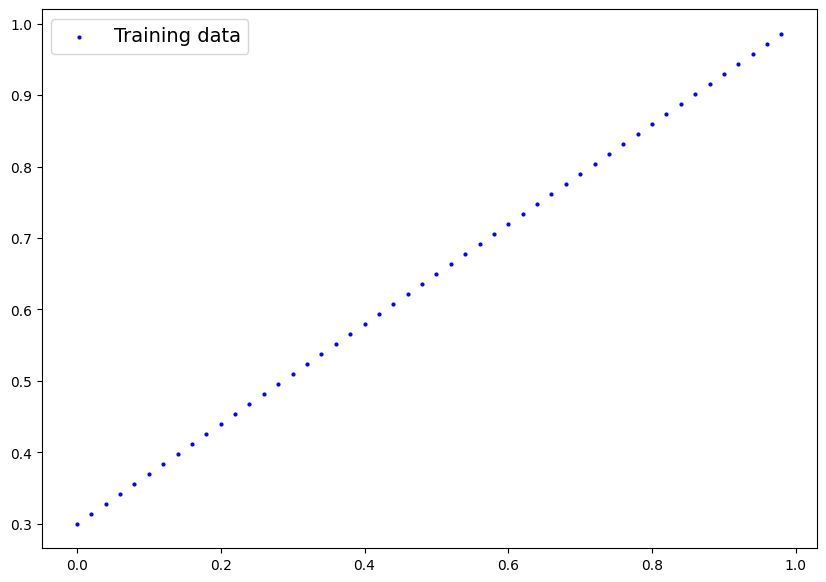

In [7]:
dataviz(X.cpu().numpy(), y.cpu().numpy())

In [8]:
# manually splitting data into training and test sets
train_split = int(len(X) * 0.8)
train_split

40

In [9]:
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

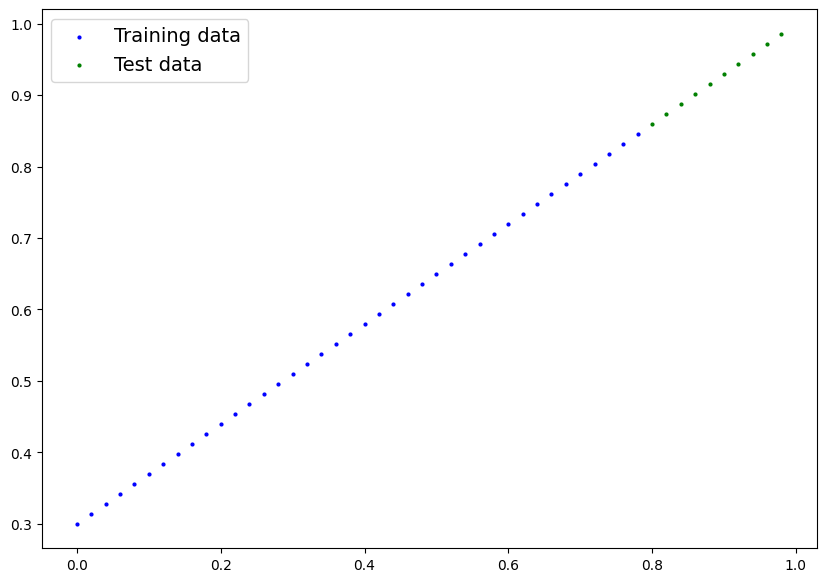

In [10]:
dataviz(X_train.cpu().numpy(), y_train.cpu().numpy(), X_test.cpu().numpy(), y_test.cpu().numpy())

In [11]:
# using scikit-learn to split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

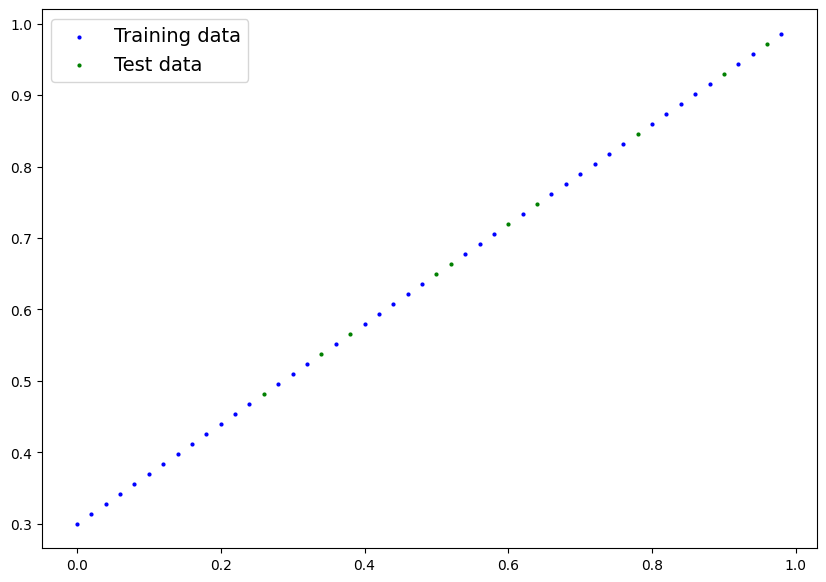

In [12]:
dataviz(X_train.cpu().numpy(), y_train.cpu().numpy(), X_test.cpu().numpy(), y_test.cpu().numpy())

## Build model

In this example, we **know** how the data was created and the parameters that were used to create it. In a real-world scenario, we would not know these things. We would have to use the data to learn the parameters. In order to do this, the model starts with random parameters and updates them using *gradient descent* and *backpropagation*.

* `nn.Module`: base class for all neural network modules

* `nn.Parameter`: tensor to be added to `parameters()` iterator   initialize model parameters to be used in various computations (these could be different layers from `torch.nn`, single parameters, hard-coded values or functions)

* `requires_grad=True`: means PyTorch will track the gradients of this specific parameters for use with `torch.autograd` and gradient descent (for many `torch.nn` modules, `requires_grad=True` is set by default)

* `forward()`: any subclass of `nn.Module` needs to override `forward()` (this defines the forward pass of the model)

* `torch.inference_mode()`: disables gradient tracking (this is useful for inference, when we are not interested in the gradients)

In [13]:
class LinearRegressionModel(nn.Module):
  """
    A linear regression model for fitting data generated by a linear function.

    This class represents a simple linear regression model with two learnable parameters:
    - weights: The coefficient for the linear relationship.
    - bias: The y-intercept.

    The model is used for predicting output values based on input features, assuming that the
    data follows a linear relationship. It can be trained using gradient descent to minimize
    the loss and fit the linear model to the given data.

    Attributes:
        weights (nn.Parameter): Learnable parameter for the linear coefficient.
        bias (nn.Parameter): Learnable parameter for the y-intercept.
    """
  def __init__(self):
    super().__init__()

    self.weights = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
    self.bias = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)

  def forward(self, x: torch.tensor) -> torch.tensor:
    """
    Predicts output values based on input features.

    Args:
      input_data (torch.Tensor): Input features.

    Returns:
      torch.Tensor: Predicted output values.
    """
    return self.weights * x + self.bias

In [14]:
torch.manual_seed(42)

model = LinearRegressionModel().to(device)
next(model.parameters()).device

device(type='cpu')

In [15]:
import copy

init_params = copy.deepcopy(model.state_dict())
init_params

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [16]:
# making predictions using the forward() method
y_pred = model.forward(X_train)
y_pred

tensor([0.2096, 0.1557, 0.3780, 0.1827, 0.1490, 0.1692, 0.4049, 0.4386, 0.4453,
        0.2298, 0.1894, 0.2366, 0.2904, 0.3578, 0.3376, 0.1288, 0.4251, 0.3106,
        0.3510, 0.1625, 0.3241, 0.2029, 0.3712, 0.1355, 0.2702, 0.1423, 0.4184,
        0.3645, 0.2837, 0.3982, 0.1961, 0.2770, 0.2500, 0.4588, 0.2635, 0.1759,
        0.4116, 0.2231, 0.3174, 0.3847], grad_fn=<AddBackward0>)

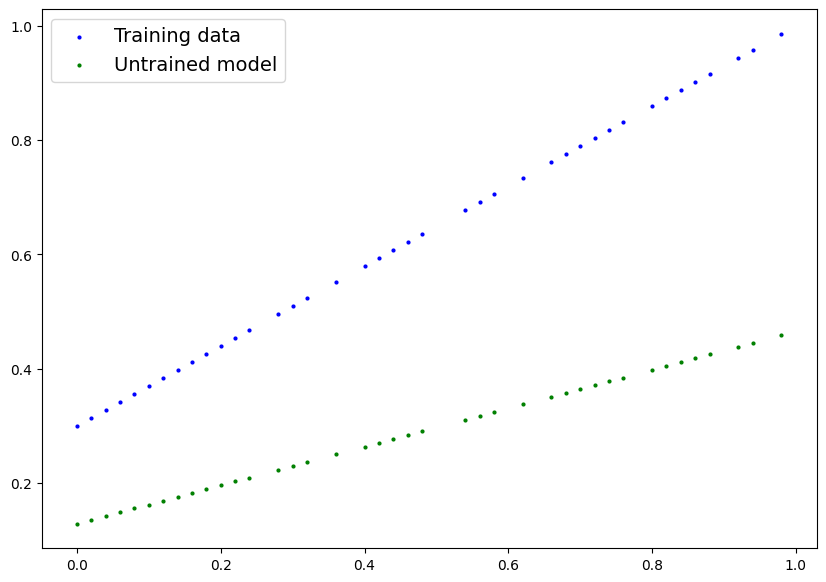

In [18]:
dataviz(
  X_train.cpu().numpy(), 
  y_train.cpu().numpy(), 
  X_train.cpu().numpy(), 
  y_pred.detach().cpu().numpy(), 
  optional_label="Untrained model"
)

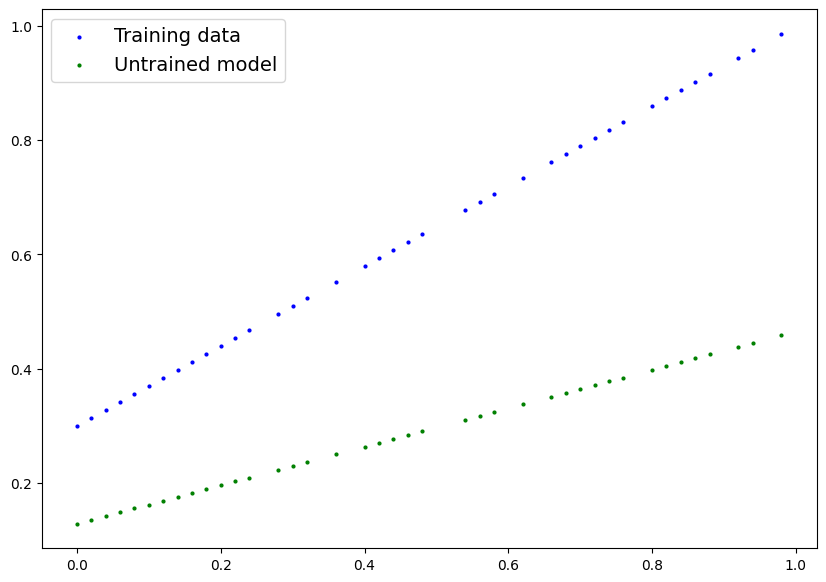

In [19]:
# making predictions using torch.inference_mode() context manager
with torch.inference_mode():
  y_pred = model(X_train)
  dataviz(
    X_train.cpu().numpy(), 
    y_train.cpu().numpy(), 
    X_train.cpu().numpy(), 
    y_pred.detach().cpu().numpy(), 
    optional_label="Untrained model"
  )

## Train model

**Loss function**: a function that takes in the model's predictions and the ground truth and outputs a number that represents how well the model is doing

* `nn.L1Loss`: mean absolute error between the predictions and the ground truth

**Optimizer**: an algorithm that updates the parameters of the model in order to minimize the loss

* `torch.optim`: package implementing various optimization algorithms

* `optim.SGD`: stochastic gradient descent
    - lr: learning rate hyperparameter

**Training loop**: a loop that iterates over the data and updates the parameters of the model

* 1. loop through the data (one batch at a time)
* 2. forward pass (compute model output for each batch)
* 3. compute loss (compare forward pass output with ground truth labels)
* 4. optimizer zero grad (clear gradients from previous iteration)
* 5. backward pass (compute gradients with respect to loss ie. backprogation)
* 6. optimizer step (update parameters using gradients ie. gradient descent)

**Evaluation**: a function that computes a metric that represents how well the model is doing. This is used to monitor the model's progress during training and to evaluate the model at the end.

In [20]:
# set up loss function
loss_fn = nn.L1Loss()
loss_fn

L1Loss()

In [21]:
# set up optimizer
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.015)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.015
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [22]:
# set up training loop
epochs = 101

# store variable values for plotting
epoch_count = []
train_loss_values = []
test_loss_values = []

for epoch in range(epochs):
  epoch_count.append(epoch)

  # set model to training mode
  model.train()

  # forward pass
  y_train_pred = model(X_train)

  # compute loss
  train_loss = loss_fn(y_train_pred, y_train)
  train_loss_values.append(train_loss.item())
  if epoch % 20 == 0:
    print(f"Epoch: {epoch} | Train loss: {round(train_loss.item(), 2)}")

  # zero out gradients
  optimizer.zero_grad()

  # backward pass
  train_loss.backward()

  # update parameters
  optimizer.step()

  # set model to evaluation mode
  model.eval()
  with torch.inference_mode():
    y_test_pred = model(X_test)
    test_loss = loss_fn(y_test_pred, y_test)
    test_loss_values.append(test_loss.item())

    if epoch % 20 == 0:
      print(f"Epoch: {epoch} | Test loss: {round(test_loss.item(), 2)}")
      print("Model current params: ", model.state_dict())

Epoch: 0 | Train loss: 0.34
Epoch: 0 | Test loss: 0.37
Model current params:  OrderedDict([('weights', tensor([0.3437])), ('bias', tensor([0.1438]))])
Epoch: 20 | Train loss: 0.06
Epoch: 20 | Test loss: 0.06
Model current params:  OrderedDict([('weights', tensor([0.4761])), ('bias', tensor([0.3771]))])
Epoch: 40 | Train loss: 0.04
Epoch: 40 | Test loss: 0.03
Model current params:  OrderedDict([('weights', tensor([0.5516])), ('bias', tensor([0.3718]))])
Epoch: 60 | Train loss: 0.02
Epoch: 60 | Test loss: 0.02
Model current params:  OrderedDict([('weights', tensor([0.6159])), ('bias', tensor([0.3418]))])
Epoch: 80 | Train loss: 0.01
Epoch: 80 | Test loss: 0.0
Model current params:  OrderedDict([('weights', tensor([0.6799])), ('bias', tensor([0.3111]))])
Epoch: 100 | Train loss: 0.01
Epoch: 100 | Test loss: 0.01
Model current params:  OrderedDict([('weights', tensor([0.7005])), ('bias', tensor([0.3066]))])


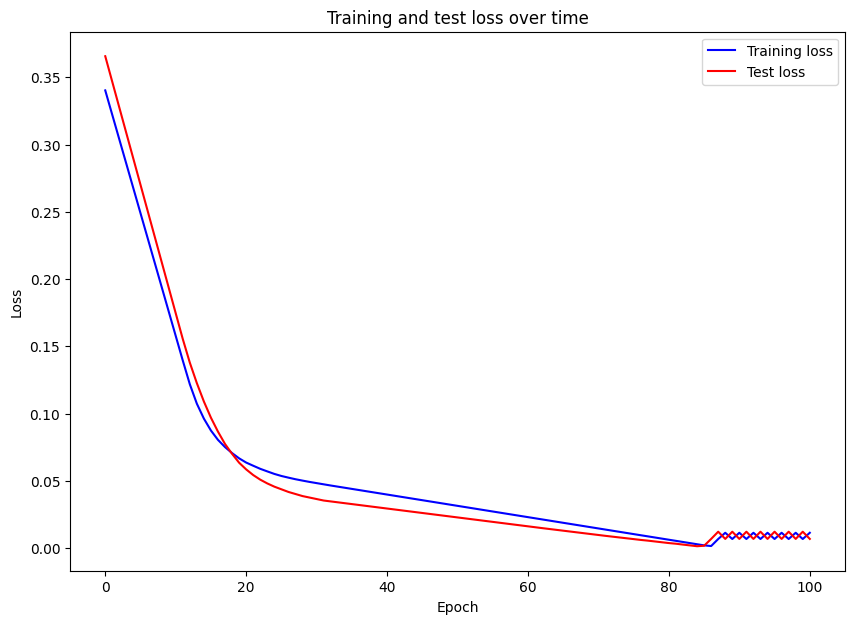

In [23]:
# plot loss values
plt.figure(figsize=(10, 7))
plt.plot(epoch_count, train_loss_values, color='blue', label='Training loss')
plt.plot(epoch_count, test_loss_values, color='red', label='Test loss')
plt.title('Training and test loss over time')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

Data params: (weights: 0.7, bias: 0.3)
Model initial (random) params: OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])
Model final (trained) params: OrderedDict([('weights', tensor([0.7005])), ('bias', tensor([0.3066]))])


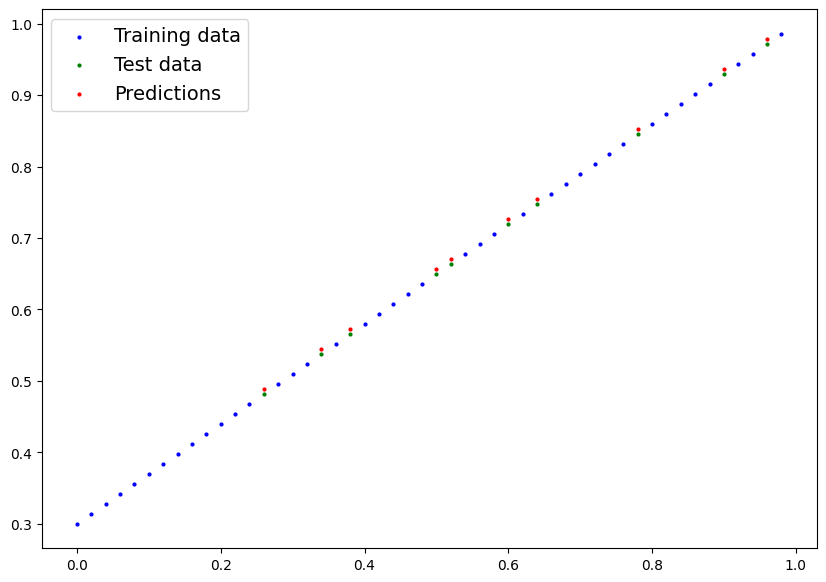

In [24]:
# make predictions using the trained model
with torch.inference_mode():
  y_test_pred = model(X_test)

  print(f"Data params: (weights: {weight}, bias: {bias})")
  print(f"Model initial (random) params: {init_params}")
  print(f"Model final (trained) params: {model.state_dict()}")

  dataviz(
    X_train.cpu().numpy(), 
    y_train.cpu().numpy(), 
    X_test.cpu().numpy(), 
    y_test.cpu().numpy(), 
    y_test_pred.detach().cpu().numpy()
  )

## Save and load trained model

**`torch.save`**: save a model's parameters to disk

* `state_dict`: a dictionary containing a model's parameters

**`torch.load`**: load a model's parameters from disk

* `model.load_state_dict`: load a model's parameters from a dictionary

In [25]:
from pathlib import Path

Path("models").mkdir(exist_ok=True)
torch.save(obj=model.state_dict(), f='./models/linear_regression_model.pt')

In [26]:
!ls -l ./models

total 8
-rw-r--r--  1 marcosf  staff  1656 Nov  3 12:00 linear_regression_model.pt


In [27]:
loaded_model = LinearRegressionModel()
loaded_model.load_state_dict(torch.load('./models/linear_regression_model.pt'))

model.state_dict(), loaded_model.state_dict()

(OrderedDict([('weights', tensor([0.7005])), ('bias', tensor([0.3066]))]),
 OrderedDict([('weights', tensor([0.7005])), ('bias', tensor([0.3066]))]))

## Optional implementation

This optional implementation is a more concise version of the above code. It uses the `nn.Linear` module, which applies a linear transformation to the incoming data: `y = xA^T + b`. It also uses the `nn.MSELoss` loss function, which computes the mean squared error between the predictions and the ground truth.

**Notice**: the `nn.Linear` module applies the transpose of the weights matrix `A` to the inputs `x`. Therefore, we need to call `.unsqueeze(dim=1)` on the inputs `x` to add an extra dimension (of size 1) to the inputs `x` before passing them to the model.

In [28]:
class LinearRegressionModelV2(nn.Module):
  """
    A linear regression model for fitting data generated by a linear function.

    This class represents a simple linear regression model with two learnable parameters:
    - weights: The coefficient for the linear relationship.
    - bias: The y-intercept.

    The model is used for predicting output values based on input features, assuming that the
    data follows a linear relationship. It can be trained using gradient descent to minimize
    the loss and fit the linear model to the given data.

    Attributes:
        linear (nn.Linear): A linear layer for the linear regression model.

    Args:
        in_features (int): The number of input features.
        out_features (int): The number of output features.
  """
  def __init__(self):
    super().__init__()

    self.linear = nn.Linear(1, 1)

  def forward(self, x: torch.tensor) -> torch.tensor:
    """
    Predicts output values based on input features.

    Args:
      input_data (torch.Tensor): Input features.

    Returns:
      torch.Tensor: Predicted output values.
    """
    return self.linear(x)

In [29]:
X = torch.arange(start=0, end=1, step=0.02).unsqueeze_(dim=1).to(device)

weight = 0.7
bias = 0.3

y = (bias + weight * X).to(device)

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [31]:
torch.manual_seed(42)

model2 = LinearRegressionModelV2().to(device)
next(model.parameters()).device

device(type='cpu')

In [32]:
# set up loss function
loss_fn = nn.L1Loss()
loss_fn

L1Loss()

In [33]:
# set up optimizer
optimizer = torch.optim.SGD(params=model2.parameters(), lr=0.015)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.015
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [34]:
# set up training loop
epochs = 101

# store variable values for plotting
epoch_count = []
train_loss_values = []
test_loss_values = []

for epoch in range(epochs):
  epoch_count.append(epoch)

  # set model to training mode
  model2.train()

  # forward pass
  y_train_pred = model2(X_train)

  # compute loss
  train_loss = loss_fn(y_train_pred, y_train)
  train_loss_values.append(train_loss.item())
  if epoch % 20 == 0:
    print(f"Epoch: {epoch} | Train loss: {round(train_loss.item(), 2)}")

  # zero out gradients
  optimizer.zero_grad()

  # backward pass
  train_loss.backward()

  # update parameters
  optimizer.step()

  # set model to evaluation mode
  model2.eval()
  with torch.inference_mode():
    y_test_pred = model2(X_test)
    test_loss = loss_fn(y_test_pred, y_test)
    test_loss_values.append(test_loss.item())

    if epoch % 20 == 0:
      print(f"Epoch: {epoch} | Test loss: {round(test_loss.item(), 2)}")
      print("Model current params: ", model2.state_dict())

Epoch: 0 | Train loss: 0.56
Epoch: 0 | Test loss: 0.55
Model current params:  OrderedDict([('linear.weight', tensor([[0.7576]])), ('linear.bias', tensor([0.8150]))])
Epoch: 20 | Train loss: 0.2
Epoch: 20 | Test loss: 0.17
Model current params:  OrderedDict([('linear.weight', tensor([[0.6179]])), ('linear.bias', tensor([0.5150]))])
Epoch: 40 | Train loss: 0.03
Epoch: 40 | Test loss: 0.02
Model current params:  OrderedDict([('linear.weight', tensor([[0.5910]])), ('linear.bias', tensor([0.3583]))])
Epoch: 60 | Train loss: 0.01
Epoch: 60 | Test loss: 0.01
Model current params:  OrderedDict([('linear.weight', tensor([[0.6534]])), ('linear.bias', tensor([0.3245]))])
Epoch: 80 | Train loss: 0.02
Epoch: 80 | Test loss: 0.0
Model current params:  OrderedDict([('linear.weight', tensor([[0.6963]])), ('linear.bias', tensor([0.2998]))])
Epoch: 100 | Train loss: 0.02
Epoch: 100 | Test loss: 0.0
Model current params:  OrderedDict([('linear.weight', tensor([[0.6963]])), ('linear.bias', tensor([0.2998]

Data params: (weights: 0.7, bias: 0.3)
Model initial (random) params: OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])
Model final (trained) params: OrderedDict([('linear.weight', tensor([[0.6963]])), ('linear.bias', tensor([0.2998]))])


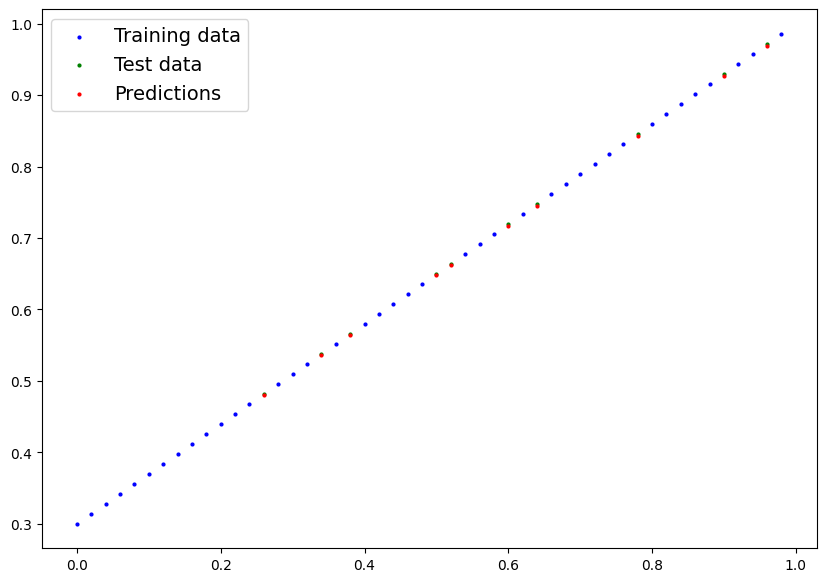

In [35]:
# make predictions using the trained model
with torch.inference_mode():
  y_test_pred = model2(X_test)

  print(f"Data params: (weights: {weight}, bias: {bias})")
  print(f"Model initial (random) params: {init_params}")
  print(f"Model final (trained) params: {model2.state_dict()}")

  dataviz(
    X_train.cpu().numpy(), 
    y_train.cpu().numpy(), 
    X_test.cpu().numpy(), 
    y_test.cpu().numpy(), 
    y_test_pred.cpu().detach().numpy()
  )

## References:

1. [Gradient descent - Wikipedia](https://en.wikipedia.org/wiki/Gradient_descent)
2. [Gradient descent - Youtube](https://www.youtube.com/watch?v=IHZwWFHWa-w)
3. [Backpropagation - Youtube](https://www.youtube.com/watch?v=Ilg3gGewQ5U)
4. [Learning rate adjustment - Official documentation](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)
5. [Saving and loading model - Official documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html)
6. [Ground truth notebook](https://www.learnpytorch.io/01_pytorch_workflow/)